In [8]:
# General utilities
import requests
import yaml

# geospatial
import shapely 
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point, MultiPoint, LineString, Polygon, MultiPolygon
from descartes import PolygonPatch

# data transformation
import numpy as np
import pandas as pd
import networkx as nx

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Extra nifty methods
from collections import Counter

# Custom functions
#import utils.utils as ut

## Core technique: routes

While routes are technically a foundation topic, I deliberately left them to this 'Applications' section. The reason is that routes (and routing) can be used in several sophisticated and useful ways. The key applications we'll work on _aggregate_ routes in meaningful and clever ways. 

| Topic | Example| Connection to routes |
|:-----:|:------:| :------------------: |
|Connectivity networks between amenities|<img src="../assets/z-connectivity-network.png" alt="drawing" width="300"/>| Aggregating routes to edges| 
|Amenity catchment analysis |<img src="../assets/park-catchment-polygons.png" alt="drawing" width="300"/>| Aggregating routes to nodes| 
|Accessibility to amenities| <img src="../assets/closer-to-z-or-bp.png" alt="drawing" width="300"/>| Aggregating routes to nodes| 
|Flows to destinations (including amenities)| <img src="../assets/flows.png" alt="drawing" width="300"/>| Aggregating routes to edges |

## Utilities
First we need import some utilities from the foundation section that we'll be re-using. In a less 'hack-y' analysis, we'd be refactoring these functions into utility scripts. 

In [6]:
## ADJUSTMENT OF A PACKAGE FUNCTION
def get_edge_colors_by_attr(G, attr, num_bins=5, cmap='viridis', start=0, stop=1, na_color='none'):
    """
    Get a list of edge colors by binning some continuous-variable attribute into
    quantiles.
    Parameters
    ----------
    G : networkx multidigraph
    attr : string
        the name of the continuous-variable attribute
    num_bins : int
        how many quantiles
    cmap : string
        name of a colormap
    start : float
        where to start in the colorspace
    stop : float
        where to end in the colorspace
    na_color : string
        what color to assign nodes with null attribute values
    Returns
    -------
    list
    """
    if num_bins is None:
        num_bins=len(G.edges())
    bin_labels = range(num_bins)
    attr_values = pd.Series([data[attr] for u, v, key, data in G.edges(keys=True, data=True)])
    cats = pd.qcut(x=attr_values.rank(method='first'), q=num_bins, labels=bin_labels)
    colors = ox.get_colors(num_bins, cmap, start, stop)
    edge_colors = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]
    return edge_colors


## CUSTOM FUNCTIONS
def try_shortest_path(origin, destination, G):
    """
    Function that gets shortest path with Networkx if it exists. 
    Returns [0] if there is no shortest path instead of an error. 
    Uses Dkijstra's algorithm by default. None others accepted at present
    Parameters
    ----------
    origin:
    destination:
    G:
    Returns
    -------
    goodpath
    """  
    try:
        goodpath = nx.shortest_path(G, origin, destination)
        return(goodpath)
    except:
        return([0])


def path_to_edge(path, G):
    """
    Function that 
    Parameters
    ----------
    G:
    path:
    Returns
    -------
    edge_nodes:
    """
    edge_nodes = list(zip(path[:-1], path[1:]))
    return(edge_nodes)

## Get Data

In [34]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# Open the API keys stored in a YAML file
with open("../utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

# Get Google Elevation API key
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]

In [35]:
G_drive = ox.graph_from_bbox(north, south, east, west, network_type='drive')
# Split the graph into node and edge dataframes 
G_drive_nodes_df, G_drive_edges_df = ox.graph_to_gdfs(G_drive)

In [36]:
G_walk = ox.graph_from_bbox(north, south, east, west, network_type='walk')
# Split the graph into node and edge dataframes 
G_walk_nodes_df, G_walk_edges_df = ox.graph_to_gdfs(G_walk)

In [9]:
# Read geospatial data of playgrounds
wcc_playgrounds = gpd.read_file('zip://../data/WCC_Playgrounds.zip')

,OBJECTID,location,suburb,playground,Housing,geometry
0,1,Salamanca Road,Kelburn,Kelburn Park Play Area,No,POINT (174.76973 -41.28487)
1,2,Farnham Street,Mornington,Farnham Street Play Area,No,POINT (174.76947 -41.31994)
2,3,Harrison Street,Brooklyn,Harrison Play Area,No,POINT (174.76482 -41.30601)
3,4,Jeypore Street,Berhampore,Jeypore Street Play Area,No,POINT (174.77340 -41.32199)
4,5,Brooklyn Road,Brooklyn,Central Park Play Area,No,POINT (174.76810 -41.29968)


## Simple routes

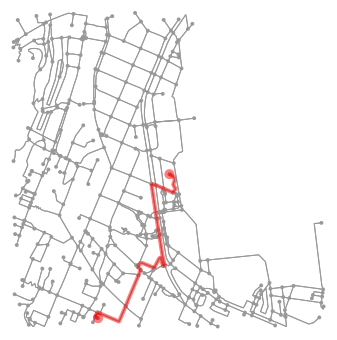

In [81]:
# Get location of Frank Kitts Park
fk = wcc_playgrounds.query('playground == "Frank Kitts Playground"').reset_index()['geometry']
destination = (fk.y[0], fk.x[0])

# Get a small radious of street network around Frank Kitts Park
G = ox.graph_from_point(destination, distance=600, network_type='walk', clean_periphery=False)

# Select origin and destination nodes
origin =  (-41.2922255, 174.7763033)
destination = destination
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)

# Get Route
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)

### Convert route to dataframe

In [111]:
p = path_to_edge(route, G)
G.get_edge_data(p[0][0], p[0][1])

{0: {'osmid': 666604818,
  'highway': 'service',
  'service': 'parking_aisle',
  'oneway': False,
  'length': 12.135}}

## Routes to connectivity networks

## Catchment analysis

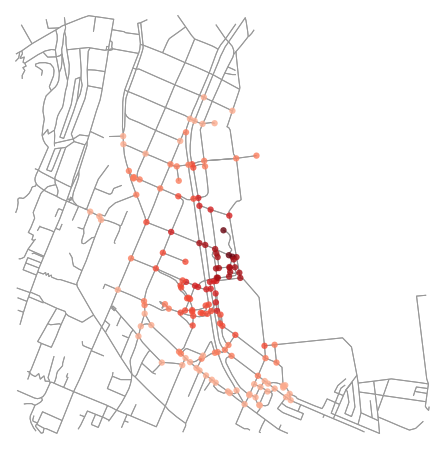

In [103]:
trip_distances = [100, 200, 300, 400, 500, 600]

iso_colors = ox.get_colors(n=len(trip_distances), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_distance, color in zip(sorted(trip_distances, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, destination_node, radius=trip_distance, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [40 if node in node_colors else 0 for node in G.nodes()]

fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

## Accessibility analysis

## Flows from routes
![](../assets/wgtn_shape.png)

In [ ]:
# get the place shape
gdf = ox.gdf_from_place('Wellington City')
gdf = ox.project_gdf(gdf, to_crs='epsg:4167')

# Can also do the following to re-project Wellington shape file
# gdf['geometry'] = gdf['geometry'].to_crs(epsg=4167)

In [11]:
# Create destination 
wgtn_stn = (-41.27803, 174.7811)
wgtn_stn_node = ox.get_nearest_node(G_drive, wgtn_stn)

# Find all driving paths to destination
p = nx.shortest_path(G_drive, target=wgtn_stn_node)
df_p = list(p.values())

In [14]:
# Convert all driving routes to paths in driving road graph
edge_path =  list(map(path_to_edge, df_p, G_drive)) 
stn_paths = [j for i in edge_path for j in i]
count_occurrences = Counter(stn_paths)

for u, v, k, data in G_drive.edges(data=True, keys=True):
  data["occurrences"] = count_occurrences[u,v]

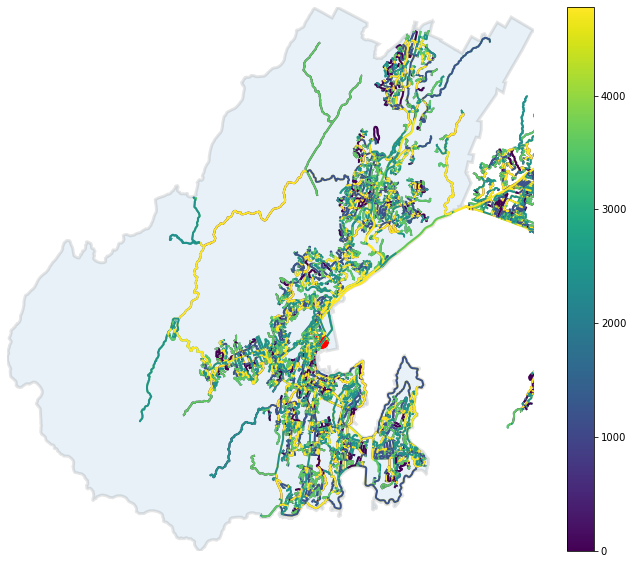

In [177]:
# Plot occurrences on map
G_nodes_flow_df, G_edges_flow_df = ox.graph_to_gdfs(G_drive)
ec = get_edge_colors_by_attr(G_drive, 'occurrences', cmap='viridis')
fig, ax = ox.plot_graph(G_drive, fig_height=10, edge_color= ec, edge_linewidth=2, node_size=0, show=False, close=False)

# Create colourbar
cmap = mpl.cm.get_cmap('viridis')
normalize = mpl.colors.Normalize(vmin=min(G_edges_flow_df['occurrences']),vmax=max(G_edges_flow_df['occurrences']))

# Add colourbar to axis
cax, _ = mpl.colorbar.make_axes(ax, location='right')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

# Add Wellington Station as a point
ax.scatter(wgtn_stn[1], wgtn_stn[0], s=200, c='r')

# Add Wellington City boundary as a polygon patch
wgtn_geometry = gdf['geometry'][0]
patch = PolygonPatch(wgtn_geometry, ec='k', linewidth=3, alpha=0.1, zorder=-1)
ax.add_patch(patch)

# Use Wellington bounding box to set limits
ax.set_xlim(west, east);
ax.set_ylim(south, north);

### Filtering the flow graph to be more meaningful

In [190]:
np.percentile(G_edges_flow_df['occurrences'], 95, axis=0)

43.0

In [194]:
## Convert to exercise
H = nx.MultiDiGraph()
for u,v,attr in G_drive.edges(data=True):
    if attr['occurrences'] >= np.percentile(G_edges_flow_df['occurrences'], 95, axis=0):
        H.add_edge(u,v, occurrences=attr['occurrences'], attr_dict=attr)
        H.node[u].update(G_drive.node[u])
        H.node[v].update(G_drive.node[v])
        
H.graph['crs'] = G_drive.graph['crs']
H.graph['name'] = G_drive.graph['name']

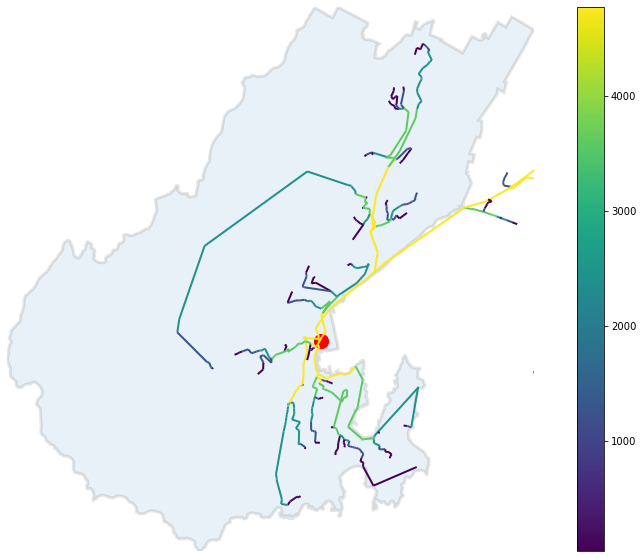

In [195]:
# Plot occurrences on map
H_nodes_flow_df, H_edges_flow_df = ox.graph_to_gdfs(H)
ec = get_edge_colors_by_attr(H, 'occurrences', cmap='viridis')
fig, ax = ox.plot_graph(H, fig_height=10, edge_color= ec, edge_linewidth=2, node_size=0, show=False, close=False)

# Create colourbar
cmap = mpl.cm.get_cmap('viridis')
normalize = mpl.colors.Normalize(vmin=min(H_edges_flow_df['occurrences']),vmax=max(H_edges_flow_df['occurrences']))

# Add colourbar to axis
cax, _ = mpl.colorbar.make_axes(ax, location='right')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

# Add Wellington Station as a point
ax.scatter(wgtn_stn[1], wgtn_stn[0], s=200, c='r')

# Add Wellington City boundary as a polygon patch
wgtn_geometry = gdf['geometry'][0]
patch = PolygonPatch(wgtn_geometry, ec='k', linewidth=3, alpha=0.1, zorder=-1)
ax.add_patch(patch)

# Use Wellington bounding box to set limits
ax.set_xlim(west, east);
ax.set_ylim(south, north);

In [197]:
H_edges_flow_df['name'] = H_edges_flow_df['attr_dict'].apply(lambda x: x.get('name'))
H_edges_flow_df.sort_values('occurrences', ascending=False).head()

,u,v,key,occurrences,attr_dict,geometry,name
749,1665398583,1665398586,0,4776,"{'osmid': 153924630, 'oneway': True, 'name': '...","LINESTRING (174.77987 -41.27763, 174.78042 -41...",Mulgrave Street
143,279426875,1665398583,0,4775,"{'osmid': 77078539, 'oneway': True, 'lanes': '...","LINESTRING (174.77989 -41.27703, 174.77987 -41...",Mulgrave Street
142,36161044,279426875,0,4226,"{'osmid': 77078539, 'oneway': True, 'lanes': '...","LINESTRING (174.77979 -41.27551, 174.77989 -41...",Mulgrave Street
664,440626613,36161044,0,4224,"{'osmid': 5184826, 'oneway': True, 'lanes': '2...","LINESTRING (174.77956 -41.27513, 174.77979 -41...",Murphy Street
663,440626612,440626613,0,4222,"{'osmid': 5184826, 'oneway': True, 'lanes': '2...","LINESTRING (174.77897 -41.27415, 174.77956 -41...",Murphy Street


In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

